In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
try:
    import torch
except ImportError:
    raise ImportError("You do not have torch installed. Run pip install torch in your terminal.")
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.linalg import expm
from collections import deque
import random
import torch.nn.functional as F

In [2]:
np.random.seed(40)
torch.manual_seed(40)

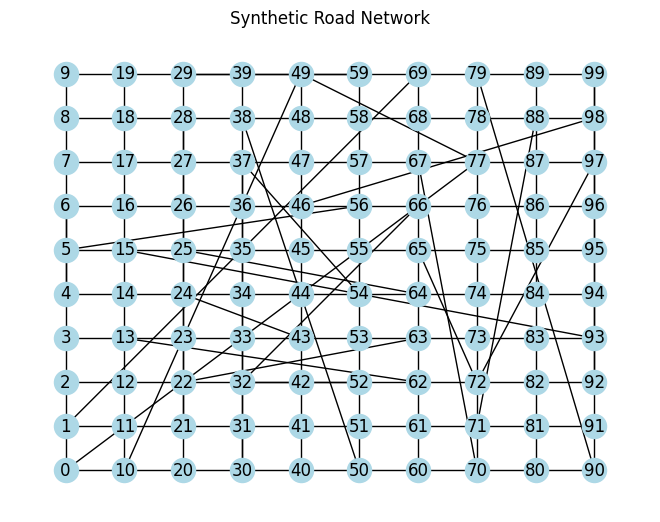

In [238]:
# Create a Synthetic Graph (Grid + Random Edges)
def create_graph(n_rows=4, n_cols=5, extra_edges=3):
    G = nx.grid_2d_graph(n_rows, n_cols)
    # Convert nodes to integer labels for easier indexing
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)
    pos = {i: node for node, i in mapping.items()}
    
    # Add a few random extra edges for realism
    nodes = list(G.nodes())
    for _ in range(extra_edges):
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    return G, pos

G, pos = create_graph(n_rows=10, n_cols=10, extra_edges=25)
num_nodes = G.number_of_nodes()
nx.draw(G, pos, with_labels=True, node_color='lightblue')
plt.title("Synthetic Road Network")
plt.show()

In [239]:
print(pos)

{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4: (0, 4), 5: (0, 5), 6: (0, 6), 7: (0, 7), 8: (0, 8), 9: (0, 9), 10: (1, 0), 11: (1, 1), 12: (1, 2), 13: (1, 3), 14: (1, 4), 15: (1, 5), 16: (1, 6), 17: (1, 7), 18: (1, 8), 19: (1, 9), 20: (2, 0), 21: (2, 1), 22: (2, 2), 23: (2, 3), 24: (2, 4), 25: (2, 5), 26: (2, 6), 27: (2, 7), 28: (2, 8), 29: (2, 9), 30: (3, 0), 31: (3, 1), 32: (3, 2), 33: (3, 3), 34: (3, 4), 35: (3, 5), 36: (3, 6), 37: (3, 7), 38: (3, 8), 39: (3, 9), 40: (4, 0), 41: (4, 1), 42: (4, 2), 43: (4, 3), 44: (4, 4), 45: (4, 5), 46: (4, 6), 47: (4, 7), 48: (4, 8), 49: (4, 9), 50: (5, 0), 51: (5, 1), 52: (5, 2), 53: (5, 3), 54: (5, 4), 55: (5, 5), 56: (5, 6), 57: (5, 7), 58: (5, 8), 59: (5, 9), 60: (6, 0), 61: (6, 1), 62: (6, 2), 63: (6, 3), 64: (6, 4), 65: (6, 5), 66: (6, 6), 67: (6, 7), 68: (6, 8), 69: (6, 9), 70: (7, 0), 71: (7, 1), 72: (7, 2), 73: (7, 3), 74: (7, 4), 75: (7, 5), 76: (7, 6), 77: (7, 7), 78: (7, 8), 79: (7, 9), 80: (8, 0), 81: (8, 1), 82: (8, 2), 83: (8, 3), 8

In [240]:
# Install node2vec if needed: pip install node2vec
from node2vec import Node2Vec

# Generate Node2Vec embeddings (do this once at the start)
node2vec = Node2Vec(G, dimensions=16, walk_length=10, num_walks=100, workers=1)
n2v_model = node2vec.fit(window=5, min_count=1, batch_words=4)
node_embeddings_matrix = np.array([n2v_model.wv[str(i)] for i in range(num_nodes)])
node_embeddings = nn.Embedding.from_pretrained(torch.tensor(node_embeddings_matrix, dtype=torch.float32))
embedding_dim = node_embeddings_matrix.shape[1]

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:00<00:00, 274.86it/s]


In [241]:
print(node2vec)
print(n2v_model)
print(node_embeddings)

Word2Vec<vocab=100, vector_size=16, alpha=0.025>
Embedding(100, 16)


In [242]:
# Precompute heat kernels for a range of t (e.g., t in [0.1, 0.5, 1, 2, 5])
def precompute_heat_kernels(G, t_values):
    A = nx.to_numpy_array(G)
    D = np.diag([G.degree(i) for i in range(num_nodes)])
    L = A - D
    kernels = {}
    for t in t_values:
        C = expm(t * L)
        C = C / C.sum(axis=1, keepdims=True)
        kernels[t] = C
    return kernels

t_values = [0.1, 0.5, 1, 2, 5]
heat_kernels = precompute_heat_kernels(G, t_values)

In [243]:
heat_kernels[0.1]

array([[7.51413786e-01, 7.13102490e-02, 3.61605360e-03, ...,
        1.10241241e-04, 8.18134309e-06, 3.95546881e-07],
       [7.13102490e-02, 6.84041146e-01, 7.13184090e-02, ...,
        2.77666724e-06, 3.89232223e-07, 2.93338613e-06],
       [3.61605360e-03, 7.13184090e-02, 7.51751870e-01, ...,
        1.66181837e-07, 9.43275876e-09, 5.92720479e-08],
       ...,
       [1.10241241e-04, 2.77666724e-06, 1.66181837e-07, ...,
        6.83719465e-01, 6.79250663e-02, 3.50338375e-03],
       [8.18134309e-06, 3.89232223e-07, 9.43275876e-09, ...,
        6.79250663e-02, 6.83714535e-01, 7.13099804e-02],
       [3.95546881e-07, 2.93338613e-06, 5.92720479e-08, ...,
        3.50338375e-03, 7.13099804e-02, 7.51746026e-01]])

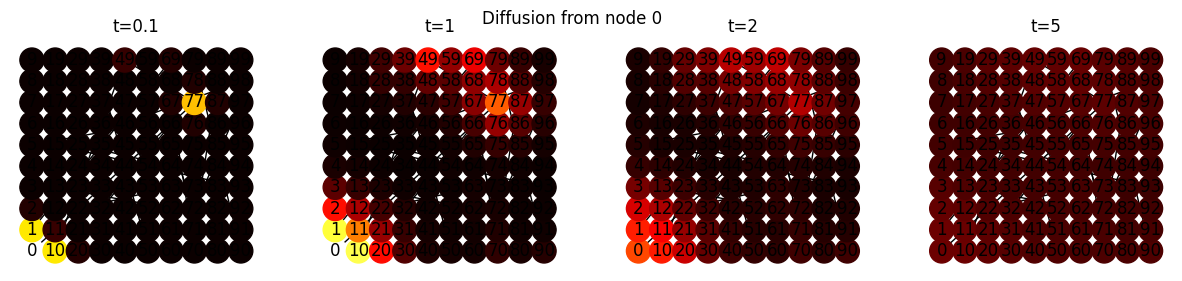

In [244]:
def plot_diffusion(node, steps=[0.1, 1, 2, 5]):
    fig, axs = plt.subplots(1, len(steps), figsize=(15, 3))
    for i, t in enumerate(steps):
        Ct = heat_kernels[t]
        p = np.zeros(num_nodes)
        p[node] = 10
        p = p @ Ct
        nx.draw(G, pos, node_color=p, cmap='hot', vmin=0, vmax=1, ax=axs[i], with_labels=True)
        axs[i].set_title(f"t={t}")
    plt.suptitle(f"Diffusion from node {node}")
    plt.show()

plot_diffusion(0)

In [245]:
def find_paths(G, num_paths=100, max_length=10):
    nodes = list(G.nodes())
    paths = []
    for _ in range(num_paths):
        while True:
            ori, dst = np.random.choice(nodes, 2, replace=False)
            try:
                # Always start with a valid shortest path
                path = nx.shortest_path(G, ori, dst)
                # Optionally, add a detour at a random position
                if len(path) > 3 and np.random.rand() < 0.3:
                    idx = np.random.randint(1, len(path)-1)
                    prev = path[idx-1]
                    curr = path[idx]
                    # Only add a neighbor of curr that is not already in the path
                    neighbors = [n for n in G.neighbors(curr) if n not in path]
                    if neighbors:
                        detour = neighbors[0]
                        # Insert detour between curr and next, ensuring connectivity
                        path = path[:idx+1] + [detour] + path[idx+1:]
                        # Ensure the detour is connected to both curr and next
                        if not (G.has_edge(curr, detour) and G.has_edge(detour, path[idx+1])):
                            continue  # Skip if not actually connected
                # Validate path connectivity
                if 3 < len(path) <= max_length and all(G.has_edge(path[i], path[i+1]) for i in range(len(path)-1)):
                    paths.append((ori, dst, path))
                    break
            except nx.NetworkXNoPath:
                continue
    return paths

paths = find_paths(G, 1000, 20)
print(f"Generated {len(paths)} OD-path samples.")

Generated 1000 OD-path samples.


In [247]:
for ori, dst, path in paths:
    assert all(G.has_edge(path[i], path[i+1]) for i in range(len(path)-1)), f"Invalid path: {path}"

In [248]:
def diffuse_path(path, t):
    C = heat_kernels[t]
    noisy_path = []
    for node in path:
        p = np.zeros(num_nodes)
        p[node] = 1
        p = p @ C
        noisy_node = np.random.choice(num_nodes, p=p)
        noisy_path.append(noisy_node)
    return noisy_path

origin,destination,path = paths[1]
noisy_path = diffuse_path(path, t = 1.0)
print("Original:", path)
print("Noisy:", noisy_path)

Original: [92, 82, 72, 62, 61, 51]
Noisy: [46, 15, 99, 13, 21, 62]


## Unfinished

In [249]:
class ReverseDiffusionModel(nn.Module):
    def __init__(self, num_nodes, embedding_dim, hidden_dim=64, n_heads=2):
        super().__init__()
        self.embedding = node_embeddings  # Now using Node2Vec
        self.t_embed = nn.Linear(1, hidden_dim)
        self.OD_embed = nn.Linear(2 * embedding_dim, hidden_dim)
        self.spatial_fc = nn.Linear(2, hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=n_heads, batch_first=True)
        self.conv1 = nn.Conv1d(embedding_dim + hidden_dim * 3, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim, num_nodes)

    def forward(self, noisy_path, t, ori, dst, mask, pos, dst_pos):
        batch_size, path_len = noisy_path.shape
        node_embs = self.embedding(noisy_path)
        attn_out, _ = self.attn(node_embs, node_embs, node_embs, key_padding_mask=~mask)
        spatial_feats = []
        for b in range(batch_size):
            feats = []
            for i in range(path_len):
                n = noisy_path[b, i].item()
                node_xy = np.array(pos[n])
                dst_xy = np.array(dst_pos[b])
                dist = np.linalg.norm(node_xy - dst_xy)
                direction = 0.0
                if np.linalg.norm(node_xy - dst_xy) > 1e-6:
                    direction = np.dot((dst_xy - node_xy), [1,0]) / (np.linalg.norm(dst_xy - node_xy) + 1e-8)
                feats.append([dist, direction])
            spatial_feats.append(feats)
        spatial_feats = torch.tensor(spatial_feats, dtype=torch.float32, device=node_embs.device)
        spatial_embs = self.spatial_fc(spatial_feats)
        t_emb = self.t_embed(t.view(-1, 1)).unsqueeze(1).repeat(1, path_len, 1)
        OD_emb = self.OD_embed(torch.cat([self.embedding(ori), self.embedding(dst)], dim=-1)).unsqueeze(1).repeat(1, path_len, 1)
        x = torch.cat([attn_out, t_emb, OD_emb, spatial_embs], dim=-1).permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        logits = self.fc(x)
        return logits

In [252]:
def prepare_batch(paths, pos, batch_size=16):
    batch = random.sample(paths, batch_size)
    max_len = max(len(p[2]) for p in batch)
    noisy_paths, clean_paths, oris, dsts, ts, masks, dst_pos = [], [], [], [], [], [], []
    for ori, dst, path in batch:
        t = np.random.choice(t_values)
        noisy = diffuse_path(path, t)
        pad_len = max_len - len(path)
        noisy += [0]*pad_len
        path += [0]*pad_len
        mask = [1]* (len(path)-pad_len) + [0]*pad_len
        # Enforce O/D at endpoints
        noisy[0] = ori
        noisy[len(path)-pad_len-1] = dst
        path[0] = ori
        path[len(path)-pad_len-1] = dst
        mask[0] = 0  # Mask loss for origin
        mask[len(path)-pad_len-1] = 0  # Mask loss for destination
        noisy_paths.append(noisy)
        clean_paths.append(path)
        oris.append(ori)
        dsts.append(dst)
        ts.append(t)
        masks.append(mask)
        dst_pos.append(pos[dst])
    return (torch.LongTensor(noisy_paths),
            torch.LongTensor(clean_paths),
            torch.LongTensor(oris),
            torch.LongTensor(dsts),
            torch.FloatTensor(ts),
            torch.BoolTensor(masks),
            dst_pos)


model = ReverseDiffusionModel(num_nodes, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Training
n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    noisy_paths, clean_paths, oris, dsts, ts, masks, dst_pos = prepare_batch(paths, pos, batch_size=32)
    logits = model(noisy_paths, ts, oris, dsts, masks, pos, dst_pos)
    # Mask out padded positions in loss
    logits = logits.view(-1, num_nodes)
    clean_paths = clean_paths.view(-1)
    masks_flat = masks.view(-1)
    loss = loss_fn(logits[masks_flat], clean_paths[masks_flat])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 4.6115
Epoch 5, Loss: 4.5487
Epoch 10, Loss: 4.4259
Epoch 15, Loss: 4.0225
Epoch 20, Loss: 3.9821
Epoch 25, Loss: 4.0008
Epoch 30, Loss: 3.7137
Epoch 35, Loss: 3.8380
Epoch 40, Loss: 3.6127
Epoch 45, Loss: 3.6987
Epoch 50, Loss: 3.6853
Epoch 55, Loss: 3.5492
Epoch 60, Loss: 3.4697
Epoch 65, Loss: 3.4503
Epoch 70, Loss: 3.2441
Epoch 75, Loss: 3.5664
Epoch 80, Loss: 3.2923
Epoch 85, Loss: 3.0203
Epoch 90, Loss: 3.3012
Epoch 95, Loss: 3.3422
Epoch 100, Loss: 3.1356
Epoch 105, Loss: 3.2735
Epoch 110, Loss: 3.1904
Epoch 115, Loss: 3.0056
Epoch 120, Loss: 2.9495
Epoch 125, Loss: 2.8593
Epoch 130, Loss: 3.1027
Epoch 135, Loss: 3.1546
Epoch 140, Loss: 2.7302
Epoch 145, Loss: 2.9359
Epoch 150, Loss: 2.7338
Epoch 155, Loss: 3.1138
Epoch 160, Loss: 2.9467
Epoch 165, Loss: 2.5156
Epoch 170, Loss: 2.9271
Epoch 175, Loss: 2.5699
Epoch 180, Loss: 2.6004
Epoch 185, Loss: 2.8924
Epoch 190, Loss: 2.6986
Epoch 195, Loss: 2.4966
Epoch 200, Loss: 2.5776
Epoch 205, Loss: 2.7703
Epoch 210, Los

In [293]:
def beam_search_path(model, G, ori, dst, pos, beam_width=5, max_len=20, t=2.0):
    model.eval()
    beams = [([ori], 0.0)]  # Each beam is (path, cumulative_log_prob)
    dst_pos = [pos[dst]]
    for step in range(max_len - 1):
        new_beams = []
        for path, log_prob in beams:
            current = path[-1]
            # Only allow neighbors (and destination if it's a neighbor)
            neighbors = list(G.neighbors(current))
            if dst not in neighbors and current != dst:
                candidates = neighbors
            else:
                candidates = neighbors + ([dst] if dst in neighbors else [])
            if not candidates:
                continue  # Dead end
            noisy_path = diffuse_path(path, t)
            pad_len = max_len - len(noisy_path)
            noisy_path_tensor = torch.LongTensor([noisy_path + [0] * pad_len])
            mask = torch.BoolTensor([[1] * len(noisy_path) + [0] * pad_len])
            ori_tensor = torch.LongTensor([ori])
            dst_tensor = torch.LongTensor([dst])
            t_tensor = torch.FloatTensor([t])
            with torch.no_grad():
                logits = model(noisy_path_tensor, t_tensor, ori_tensor, dst_tensor, mask, pos, dst_pos)
                probs = torch.softmax(logits[0, len(path) - 1], dim=-1).cpu().numpy()
            # Only consider valid next nodes (candidates)
            for n in candidates:
                prob = probs[n]
                if prob > 0:
                    new_path = path + [n]
                    new_log_prob = log_prob + np.log(prob)
                    new_beams.append((new_path, new_log_prob))
        # Prune to top beam_width beams by cumulative log probability
        new_beams = sorted(new_beams, key=lambda x: -x[1])[:beam_width]
        beams = new_beams
        # If any beam ends at dst, return the first such path
        for path, _ in beams:
            if path[-1] == dst:
                return path
        if not beams:
            break  # No valid extensions
    # If no path reaches dst, return the best partial beam
    return beams[0][0] if beams else [ori]

Planned path: [72, 82, 6]


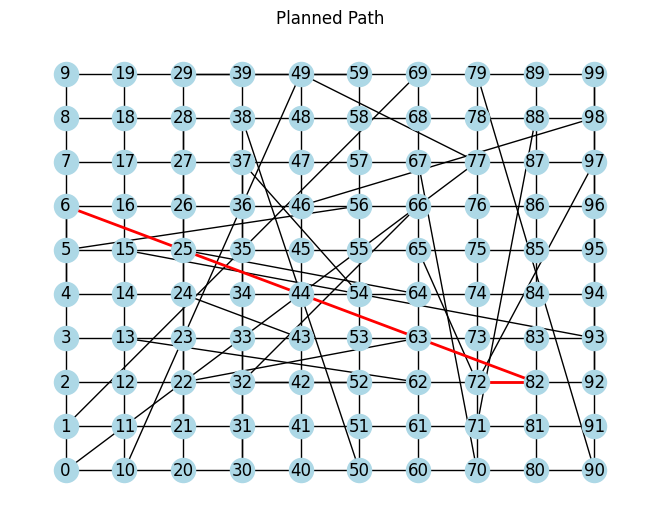

In [255]:
# Example: Plan a path from ori to dst
ori, dst, _ = random.choice(paths)
planned_path = beam_search_path(model, G, ori, dst, pos, beam_width=5, max_len=20)
print("Planned path:", planned_path)

# Visualize
def plot_path(G, pos, path, color='r', label='Planned'):
    nx.draw(G, pos, with_labels=True, node_color='lightblue')
    edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, width=2, label=label)
    plt.title(label)
    plt.show()

plot_path(G, pos, planned_path, color='r', label='Planned Path')

In [256]:
def conditional_plan(model, G, ori, dst, pos, max_len=20, t=2.0):
    model.eval()
    path = [ori]
    dst_pos = [pos[dst]]
    for step in range(max_len-1):
        noisy_path = diffuse_path(path, t)
        pad_len = max_len - len(noisy_path)
        noisy_path_tensor = torch.LongTensor([noisy_path + [0]*pad_len])
        mask = torch.BoolTensor([[1]*len(noisy_path) + [0]*pad_len])
        ori_tensor = torch.LongTensor([ori])
        dst_tensor = torch.LongTensor([dst])
        t_tensor = torch.FloatTensor([t])
        with torch.no_grad():
            logits = model(noisy_path_tensor, t_tensor, ori_tensor, dst_tensor, mask, pos, dst_pos)
            probs = torch.softmax(logits[0, len(path)-1], dim=-1).cpu().numpy()
        current = path[-1]
        neighbors = list(G.neighbors(current)) + [dst]
        mask_arr = np.zeros(num_nodes)
        mask_arr[neighbors] = 1
        probs = probs * mask_arr
        probs = probs / probs.sum()
        next_node = np.random.choice(num_nodes, p=probs)
        path.append(next_node)
        if next_node == dst:
            break
    # Ensure the path ends at the destination
    if path[-1] != dst:
        path[-1] = dst
    return path

Planned path: [25, 64, 72]


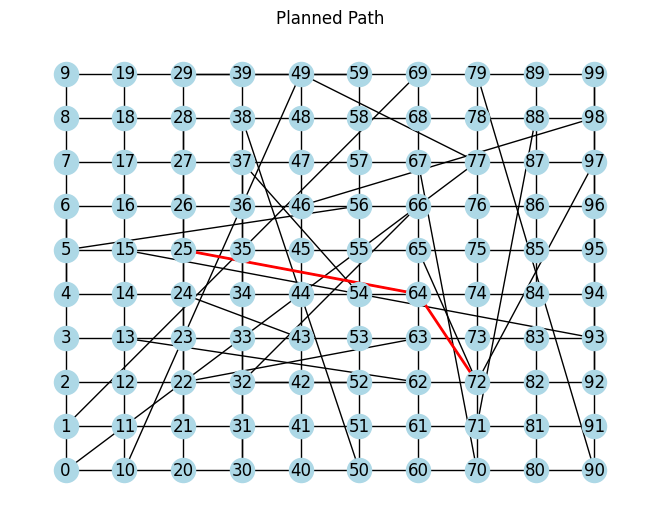

In [258]:
ori, dst, _ = random.choice(paths)
planned_path = conditional_plan(model, G, ori, dst, pos, max_len=10)
print("Planned path:", planned_path)

# Visualize
def plot_path(G, pos, path, color='r', label='Planned'):
    nx.draw(G, pos, with_labels=True, node_color='lightblue')
    edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, width=2, label=label)
    plt.title(label)
    plt.show()

plot_path(G, pos, planned_path, color='r', label='Planned Path')

In [296]:
# Cell 10: Evaluation (DTW, LCS, Hit Ratio)
from difflib import SequenceMatcher

def lcs(a, b):
    matcher = SequenceMatcher(None, a, b)
    return matcher.find_longest_match(0, len(a), 0, len(b)).size

def dtw(a, b):
    n, m = len(a), len(b)
    dp = np.full((n+1, m+1), float('inf'))
    dp[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i, j] = cost + min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1])
    return dp[n, m]

def is_valid_path(G, path):
    return all(G.has_edge(path[i], path[i+1]) for i in range(len(path)-1))

hits = []
lcs_scores = []
dtw_scores = []
for i in range(20):
    ori, dst, gt_path = random.choice(paths)
    pred_path = beam_search_path(model, G, ori, dst, pos, beam_width=5, max_len=10)
    if not is_valid_path(G, pred_path):
        hits.append(False)  # or skip appending at all
        continue
    hit = (pred_path[-1] == dst)
    hits.append(hit)
    lcs_scores.append(lcs(gt_path, pred_path))
    dtw_scores.append(dtw(gt_path, pred_path))
print(f"Hit ratio: {np.mean(hits):.2f}, Avg LCS: {np.mean(lcs_scores):.2f}, Avg DTW: {np.mean(dtw_scores):.2f}")

Hit ratio: 0.80, Avg LCS: 3.15, Avg DTW: 4.65
